123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Test MSE pH units² ...Track Histroy
📂 Processing group: Ctrl


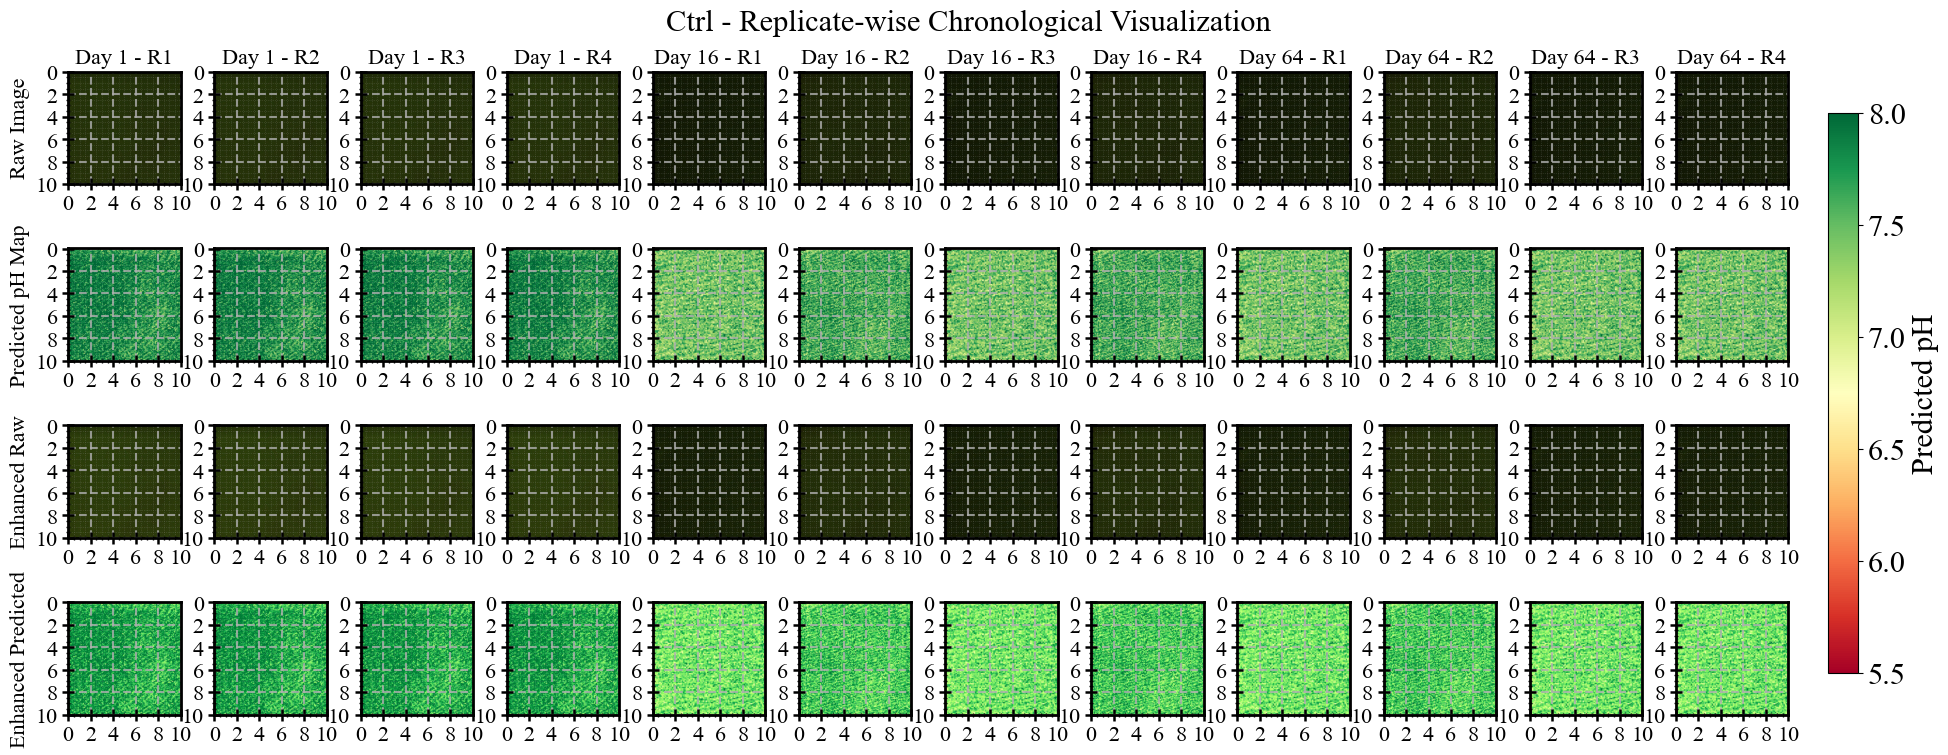

📂 Processing group: RMU


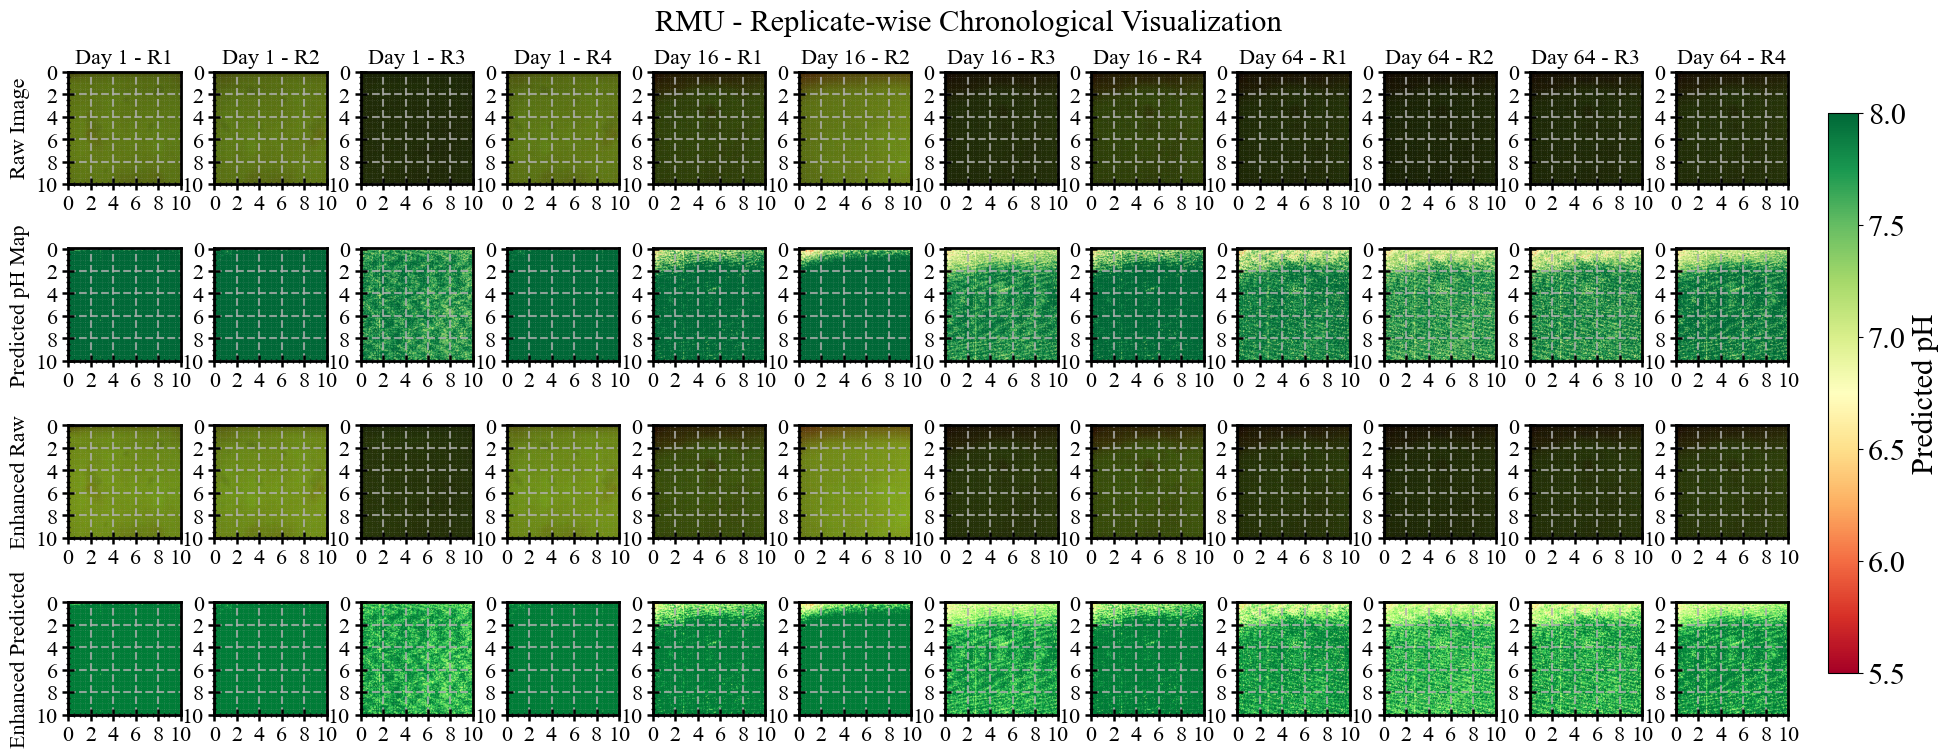

📂 Processing group: RM


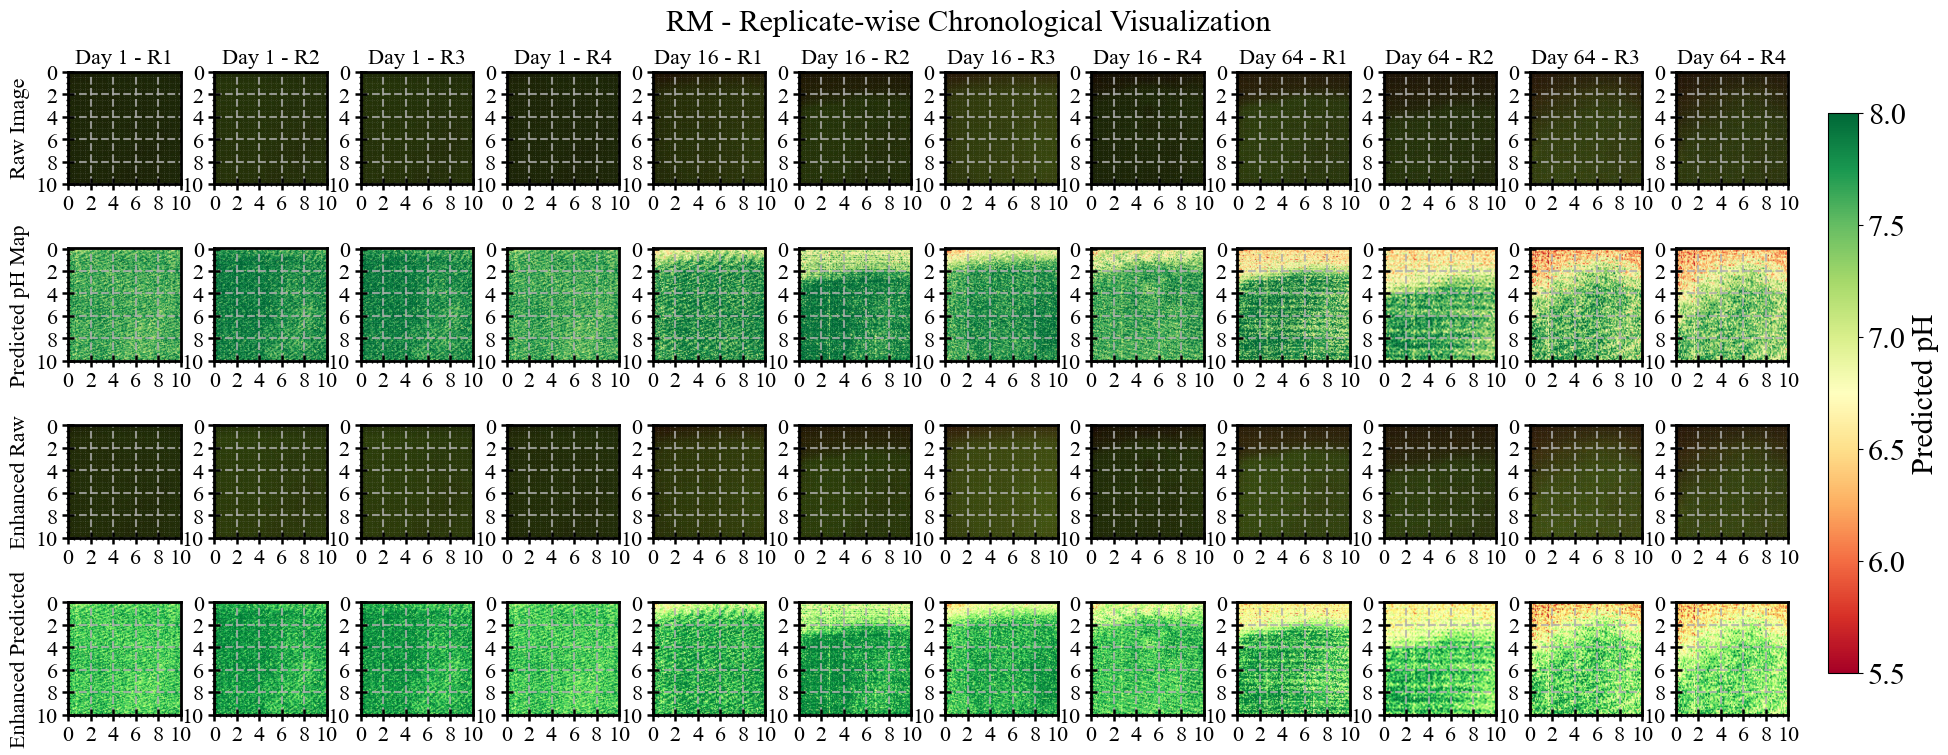

📂 Processing group: LMU


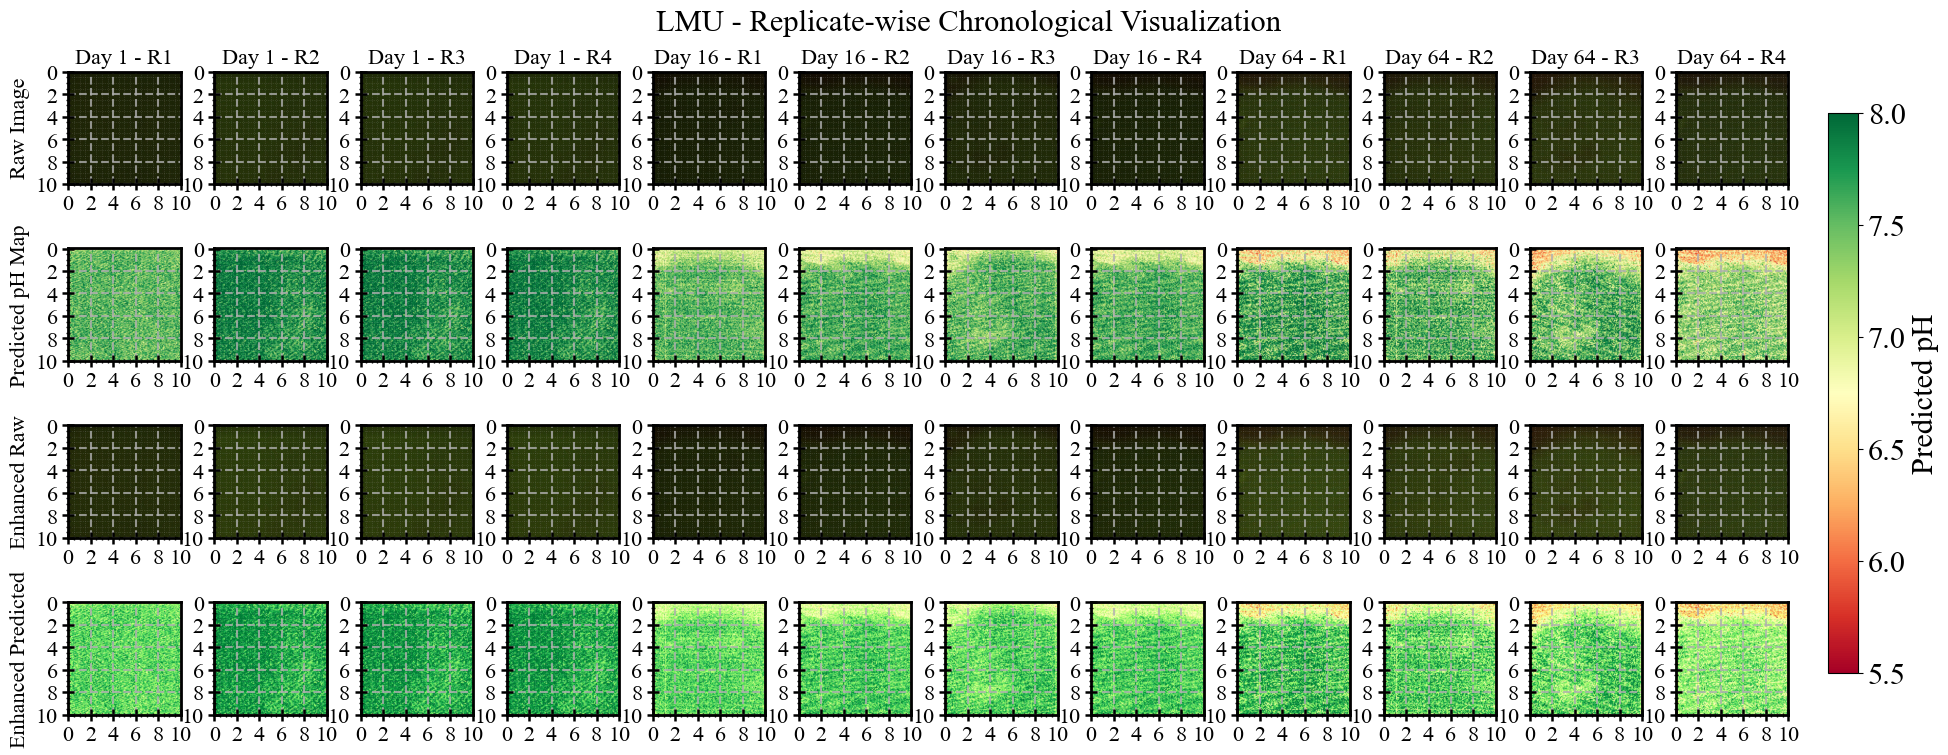

📂 Processing group: LM


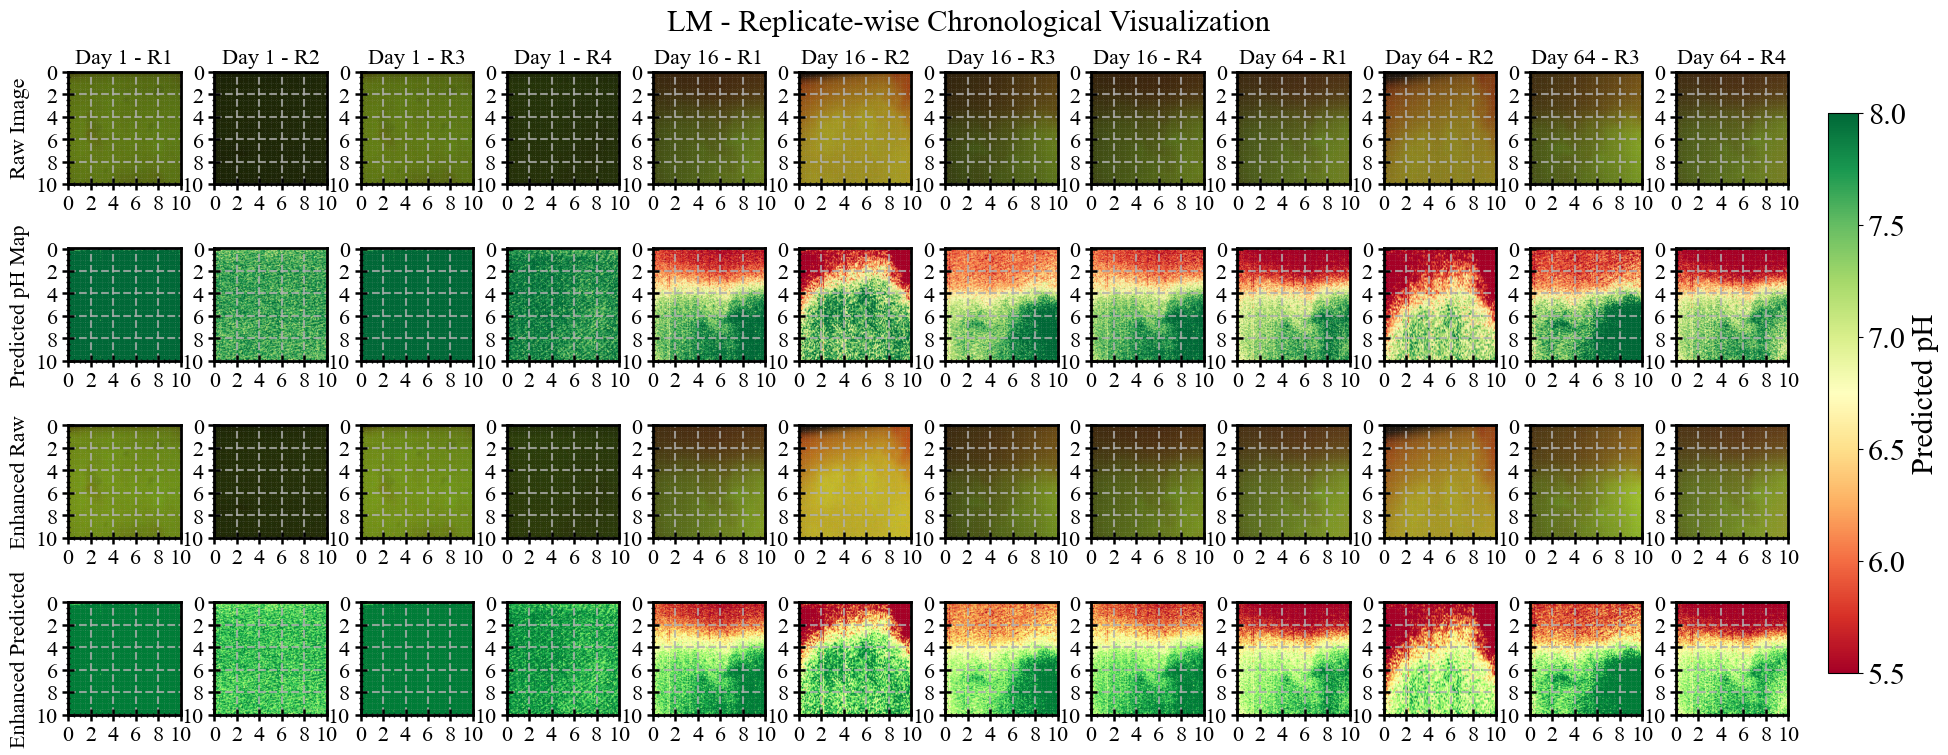

In [10]:
# ========== IMPORTS ==========
import os
import numpy as np
import tensorflow as tf
import cv2 as cv
from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from PIL import Image, ImageEnhance

plt.rcParams["font.family"] = "Times New Roman"


# ========== CONFIGURATION ==========

PH_CALIB_PATH = r'C:\Users\Kenneth\Desktop\Data\MODE1002\202403_28\pHCalib'
MODEL_PATH = 'model.keras'
SAVE_DIR = r'C:\Users\Kenneth\Desktop\Data\ProcessedFigures'

TARGET_DIRS = {
    'Ctrl': {
        1: [r"C:\Optode_Images_Raw\Ctrl\SD_1\R1",
            r"C:\Optode_Images_Raw\Ctrl\SD_1\R2",
            r"C:\Optode_Images_Raw\Ctrl\SD_1\R3",
            r"C:\Data\Optode_Images_Raw\Ctrl\SD_1\R4"],
        16: [r"\Optode_Images_Raw\Ctrl\SD_16\R1",
             r"C:\Optode_Images_Raw\Ctrl\SD_16\R2",
             r"C:\Optode_Images_Raw\Ctrl\SD_16\R3",
             r"C:\Optode_Images_Raw\Ctrl\SD_16\R4"],
        64: [r"C:\Optode_Images_Raw\Ctrl\SD_64\R1",
             r"C:\Optode_Images_Raw\Ctrl\SD_64\R2",
             r"C:\Optode_Images_Raw\Ctrl\SD_64\R3",
             r"C:\Optode_Images_Raw\Ctrl\SD_64\R4"],
    },
    'RMU': {
        1: [r"C:\Optode_Images_Raw\RMU\SD_1\R1",
            r"C:\Optode_Images_Raw\RMU\SD_1\R2",
            r"C:\Optode_Images_Raw\RMU\SD_1\R3",
            r"C:\Optode_Images_Raw\RMU\SD_1\R4"],
        16: [r"C:\Optode_Images_Raw\RMU\SD_16\R1",
             r"C:\Optode_Images_Raw\RMU\SD_16\R2",
             r"C:\Optode_Images_Raw\RMU\SD_16\R3",
             r"C:\Optode_Images_Raw\RMU\SD_16\R4"],
        64: [r"C:\Optode_Images_Raw\RMU\SD_64\R1",
             r"C:\Optode_Images_Raw\RMU\SD_64\R2",
             r"C:\Optode_Images_Raw\RMU\SD_64\R3",
             r"C:\Optode_Images_Raw\RMU\SD_64\R4"],
    },
    'RM': {
        1: [r"C:\Optode_Images_Raw\RM\SD_1\R1",
            r"C:\Optode_Images_Raw\RM\SD_1\R2",
            r"C:\Optode_Images_Raw\RM\SD_1\R3",
            r"C:\Optode_Images_Raw\RM\SD_1\R4"],
        16: [r"C:\Optode_Images_Raw\RM\SD_16\R1",
             r"C:\Optode_Images_Raw\RM\SD_16\R2",
             r"C:\Optode_Images_Raw\RM\SD_16\R3",
             r"C:\Optode_Images_Raw\RM\SD_16\R4"],
        64: [r"C:\Optode_Images_Raw\RM\SD_64\R1",
             r"C:\Optode_Images_Raw\RM\SD_64\R2",
             r"C:\Optode_Images_Raw\RM\SD_64\R3",
             r"C:\Optode_Images_Raw\RM\SD_64\R4"],
    },
    'LMU': {
        1: [r"C:\Optode_Images_Raw\LMU\SD_1\R1",
            r"C:\Optode_Images_Raw\LMU\SD_1\R2",
            r"C:\Optode_Images_Raw\LMU\SD_1\R3",
            r"C:\Optode_Images_Raw\LMU\SD_1\R4"],
        16: [r"C:\Optode_Images_Raw\LMU\SD_16\R1",
             r"C:\Optode_Images_Raw\LMU\SD_16\R2",
             r"C:\Optode_Images_Raw\LMU\SD_16\R3",
             r"C:\Optode_Images_Raw\LMU\SD_16\R4"],
        64: [r"C:\Optode_Images_Raw\LMU\SD_64\R1",
             r"C:\Optode_Images_Raw\LMU\SD_64\R2",
             r"C:\Optode_Images_Raw\LMU\SD_64\R3",
             r"C:\Optode_Images_Raw\LMU\SD_64\R4"],
    },
    'LM': {
        1: [r"C:\Optode_Images_Raw\LM\SD_1\R1",
            r"C:\Optode_Images_Raw\LM\SD_1\R2",
            r"C:\Optode_Images_Raw\LM\SD_1\R3",
            r"C:\Optode_Images_Raw\LM\SD_1\R4"],
        16: [r"C:\Optode_Images_Raw\LM\SD_16\R1",
             r"C:\Optode_Images_Raw\LM\SD_16\R2",
             r"C:\Optode_Images_Raw\LM\SD_16\R3",
             r"C:\Optode_Images_Raw\LM\SD_16\R4"],
        64: [r"C:\Optode_Images_Raw\LM\SD_64\R1",
             r"C:\Optode_Images_Raw\LM\SD_64\R2",
             r"C:\Optode_Images_Raw\LM\SD_64\R3",
             r"C:\Optode_Images_Raw\LM\SD_64\R4"],
    },
}

os.makedirs(SAVE_DIR, exist_ok=True)

# ========== FUNCTIONS ==========

def create_datasets_from_sample_ph(ph_path):
    ph_files = sorted(os.listdir(ph_path))
    datasets = np.zeros((62500 * len(ph_files), 4), dtype=np.float32)

    for i, ph in enumerate(ph_files):
        ph_v = float(ph.replace('.png', '').replace('_', '.'))
        img = io.imread(os.path.join(ph_path, ph))
        img = img[400:650, 550:800]
        rgb = np.reshape(img, (-1, 3)) / 255
        ph_values = np.ones((rgb.shape[0], 1)) * ph_v
        datasets[i * 62500:(i + 1) * 62500] = np.concatenate([rgb, ph_values], axis=1)

    return datasets

def build_model():
    x_in = tf.keras.layers.Input(shape=(3,))
    x = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(x_in)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x_out = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=x_in, outputs=x_out)
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MSE])
    return model

def enhance_image_brightness_contrast(img_array, brightness=1.2, contrast=1.0):
    img_pil = Image.fromarray(img_array)
    img_enhanced = ImageEnhance.Brightness(img_pil).enhance(brightness)
    img_enhanced = ImageEnhance.Contrast(img_enhanced).enhance(contrast)
    return np.array(img_enhanced)

def resize_image_to_shape(img, target_shape=(512, 512)): 
    return cv.resize(img, target_shape[::-1], interpolation=cv.INTER_CUBIC)


def add_colorbar(fig, ax, im, label='pH'):
    # Adjust colorbar and legend positioning
     cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
     cbar.set_label('pH Level', fontsize=14)

# Adjust legend placement
     ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=24)


def add_colorbar(fig, ax, im, label='pH'):
    # Adjust colorbar and legend positioning
  def add_colorbar(fig, ax, im, label='pH'):
    # Adjust colorbar positioning
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('pH Level', fontsize=14)
    

    
    # Adjust legend placement
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12)

def process_directory(group, model):
    days = [1, 16, 64]
    replicates = ['R1', 'R2', 'R3', 'R4']
    rows = ['Raw Image', 'Predicted pH Map', 'Enhanced Raw', 'Enhanced Predicted']
    cm_ticks = ['0', '2', '4', '6', '8', '10']
    tick_positions = np.linspace(0, 512, len(cm_ticks))

    fig, axs = plt.subplots(len(rows), len(days) * len(replicates), figsize=(20, 8))  # was (24, 10)


    fig.suptitle(f'{group} - Replicate-wise Chronological Visualization', fontsize=22)

    for d_idx, day in enumerate(days):
        folders = TARGET_DIRS[group][day]

        for r_idx, folder in enumerate(folders):
            col_idx = d_idx * len(replicates) + r_idx

            images = sorted(glob(os.path.join(folder, '*.png')))
            if not images:
                print(f"⚠️ No images found in {folder}")
                continue

            image_path = images[0]
            image = io.imread(image_path)[150:900, 200:900]

            if image.ndim == 2:
                image = np.stack([image] * 3, axis=-1)
            elif image.shape[2] == 4:
                image = image[:, :, :3]
            if image.dtype != np.uint8:
                image = (image * 255).astype(np.uint8)

            gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
            _, thresh = cv.threshold(gray, 0, 255, cv.THRESH_OTSU)
            x, y, w, h = cv.boundingRect(thresh)
            image = image[y:y + h, x:x + w]
            image = np.flipud(image)[120:-5, 20:-50]
            a1, b1, _ = image.shape

            reshaped = np.reshape(image, (-1, 3)) / 255.
            ph_predicted = model.predict(reshaped, verbose=0).reshape((a1, b1))

            pred_norm = (ph_predicted - 5.4) / (7.6 - 5.4)
            pred_colored = (plt.cm.RdYlGn(pred_norm.clip(0, 1))[:, :, :3] * 255).astype(np.uint8)

            enhanced_green = ImageEnhance.Brightness(Image.fromarray(pred_colored[:, :, 1])).enhance(1.2)
            enhanced_pred_colored = pred_colored.copy()
            enhanced_pred_colored[:, :, 1] = np.array(enhanced_green)

            enhanced_raw = enhance_image_brightness_contrast(image)

            raw_resized = resize_image_to_shape(np.flipud(image))
            pred_resized = resize_image_to_shape(np.flipud(pred_colored))
            enh_raw_resized = resize_image_to_shape(np.flipud(enhanced_raw))
            enh_pred_resized = resize_image_to_shape(np.flipud(enhanced_pred_colored))

            images_to_plot = [raw_resized, pred_resized, enh_raw_resized, enh_pred_resized]

            for row_idx in range(4):
                ax = axs[row_idx, col_idx]
                ax.imshow(images_to_plot[row_idx])
                if row_idx == 0:
                    ax.set_title(f"Day {day} - {replicates[r_idx]}", fontsize=16)
                ax.axis('on')
                ax.set_xticks(tick_positions)
                ax.set_xticklabels(cm_ticks, fontsize=16)
                ax.set_yticks(tick_positions)
                ax.set_yticklabels(cm_ticks, fontsize=16)
                ax.minorticks_on()
                ax.tick_params(axis='both', which='major', length=8, width=1.8, direction='inout')
                ax.tick_params(axis='both', which='minor', length=3, width=1.0, direction='inout')
                ax.grid(True, which='major', linestyle='--', linewidth=1.5, alpha=0.8)
                ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.3)

                for spine in ax.spines.values():
                    spine.set_linewidth(2)

    for i in range(len(rows)):
        axs[i, 0].set_ylabel(rows[i], fontsize=16)

    cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
    norm = Normalize(vmin=5.5, vmax=8.)
    sm = ScalarMappable(cmap='RdYlGn', norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Predicted pH', fontsize=22)
    cbar.ax.tick_params(labelsize=22)

    plt.subplots_adjust(left=0.05, right=0.91, top=0.92, bottom=0.08, wspace=0.3, hspace=0.25)
    plt.savefig(os.path.join(SAVE_DIR, f'{group}_replicate_visualization.png'), dpi=300)
    plt.show()

# ========== MAIN EXECUTION ==========

if __name__ == '__main__':
    datasets = create_datasets_from_sample_ph(PH_CALIB_PATH)
    train_data, test_data = train_test_split(datasets, test_size=0.1, shuffle=True)

    train_ds = tf.data.Dataset.from_tensor_slices(train_data).map(lambda x: (x[:3], x[3])).batch(50).repeat()
    test_ds = tf.data.Dataset.from_tensor_slices(test_data).map(lambda x: (x[:3], x[3])).batch(50).repeat()

    if not os.path.exists(MODEL_PATH):
        model = build_model()
        model.fit(train_ds, epochs=20, steps_per_epoch=7875,
                  validation_data=test_ds, validation_steps=875)
        model.save(MODEL_PATH)
    else:
        model = tf.keras.models.load_model(MODEL_PATH)

    x_test = test_data[:, :3]
    y_test = test_data[:, 3]
    y_pred = model.predict(x_test, batch_size=256)
    print(f'\n📊 Test MSE pH units² ...Track Histroy')

    for group in TARGET_DIRS:
        print(f"📂 Processing group: {group}")
        process_directory(group, model)





 

